In [55]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf

## Load the data

In [56]:
data_path = "DATA/"

mex_df = pd.read_csv(data_path+"Mex_daily_edac.txt", sep='\t')
mex_offset_df = pd.read_csv(data_path+"MeX_EDAC_offset.txt", sep='\t')
nac_df = pd.read_csv(data_path+"Nac_daily_edac.txt", sep='\t')
ndm_df = pd.read_csv(data_path+"Ndm_daily_edac.txt", sep='\t')
ros_nac_offset_df = pd.read_csv(data_path+"Ros_AOCS_NAC_offset.txt", sep='\t')
ros_ndm_offset_df = pd.read_csv(data_path+"Ros_AOCS_NDM_offset.txt", sep='\t')
vex_df = pd.read_csv(data_path+"VEX_NDMW0D0A_2023_01_11_12_55_55.900.txt", sep='\t')
vex_boundary_df = pd.read_csv(data_path+"VEX-ICME-boundaries.csv")

## Venus Express data

In [57]:
vex_df.DATE_TIME.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
vex_df.set_index('DATE_TIME', inplace=True)
display(vex_df.head())

,NDMW0D0A
DATE_TIME,
2005-11-09 00:09:04.575,0
2005-11-09 00:10:08.575,0
2005-11-09 00:11:12.576,0
2005-11-09 00:12:16.576,0
2005-11-09 00:13:20.577,0


In [58]:
vex_df.iloc[0]

NDMW0D0A    0
Name: 2005-11-09 00:09:04.575, dtype: int64

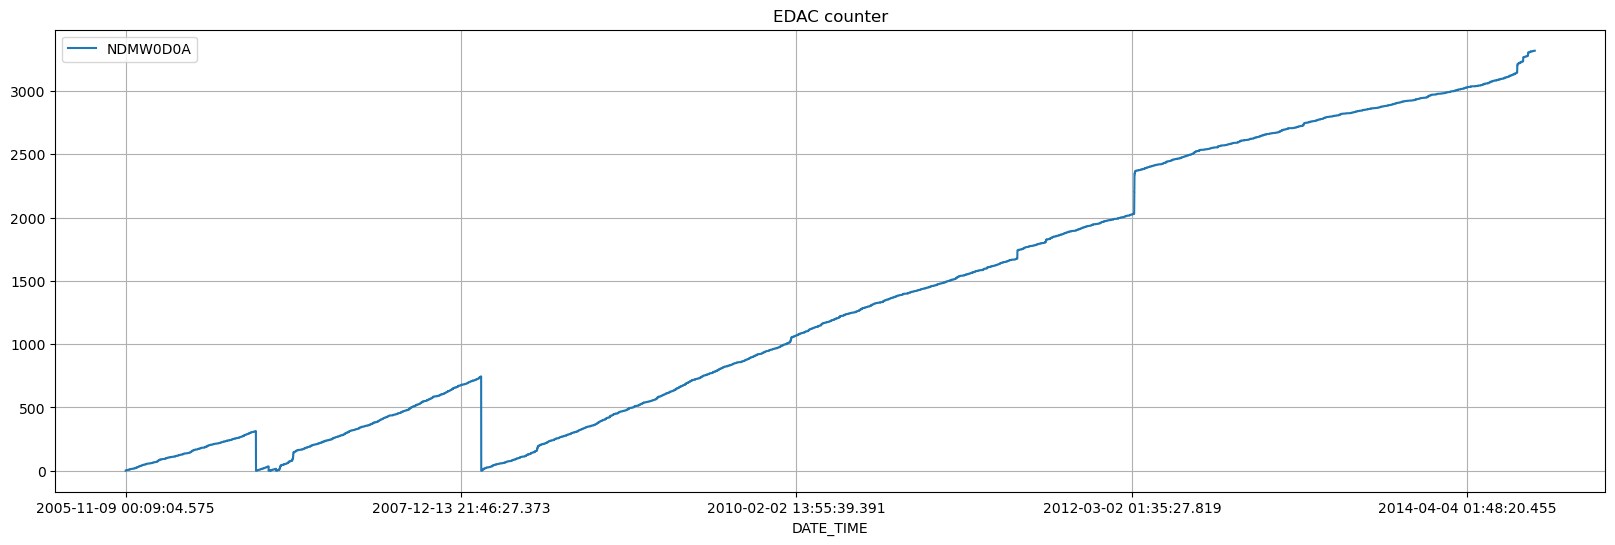

In [59]:
vex_df.plot(kind='line', figsize=(20,6))
plt.title('EDAC counter')
plt.grid()
plt.show()

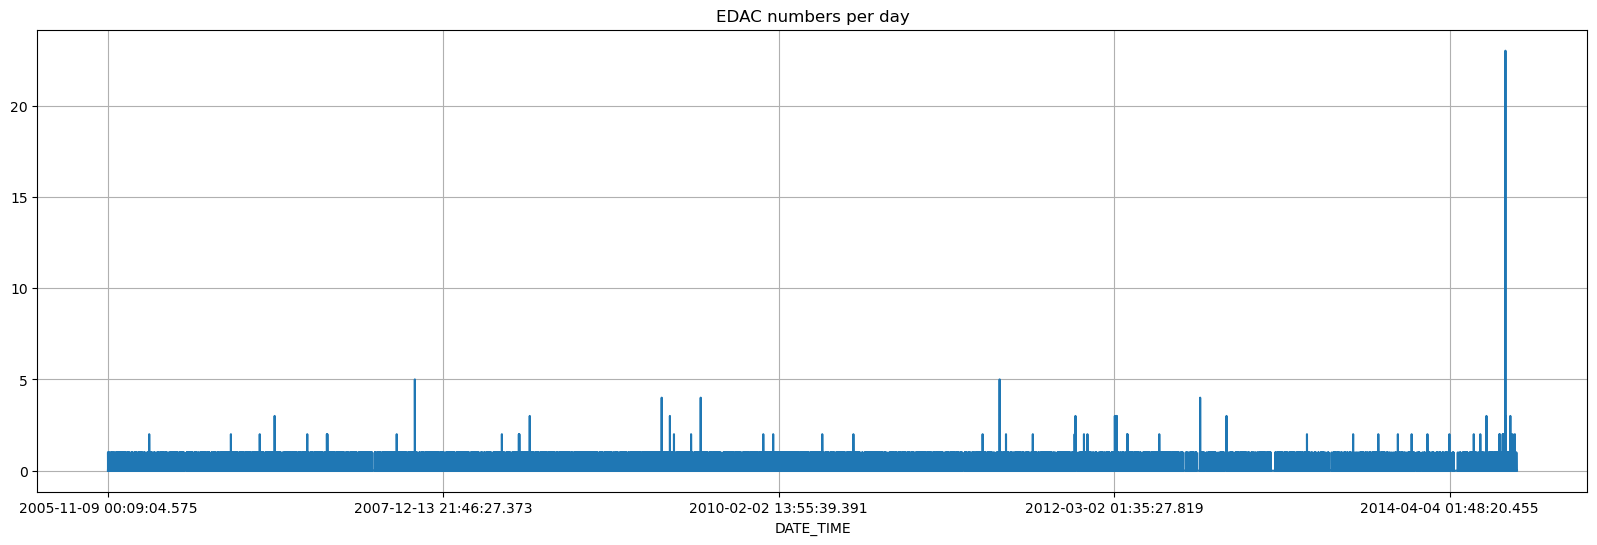

In [60]:
vex_df['EDAC'] = vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

vex_df['EDAC'].plot(kind='line', figsize=(20,6))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

Now let's visualize on top of this plot the events of CME :

In [61]:
cme_df = pd.read_csv(data_path+"CME_date_time.csv")

In [62]:
vex_df['cme'] = 0

for index, row in cme_df.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Set 'cme' column values to 1 between start_time and end_time
    vex_df.loc[(vex_df.index >= start_time) & (vex_df.index <= end_time), 'cme'] = 1

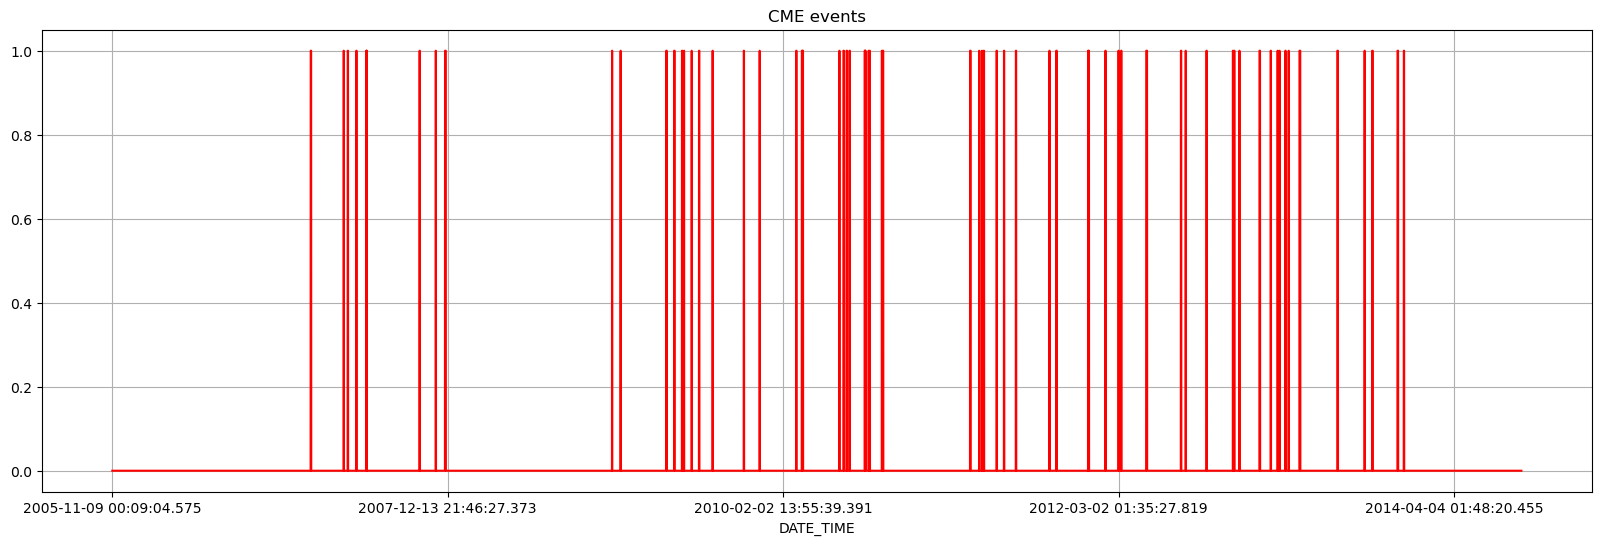

In [63]:
vex_df['cme'].plot(kind='line', figsize=(20,6), color='red')
plt.title('CME events')
plt.grid()
plt.show()

In [64]:
#start_array = cme_df['start_time'].values
vex_df['EDAC'] = vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

### Looking at EDAC and CME evants

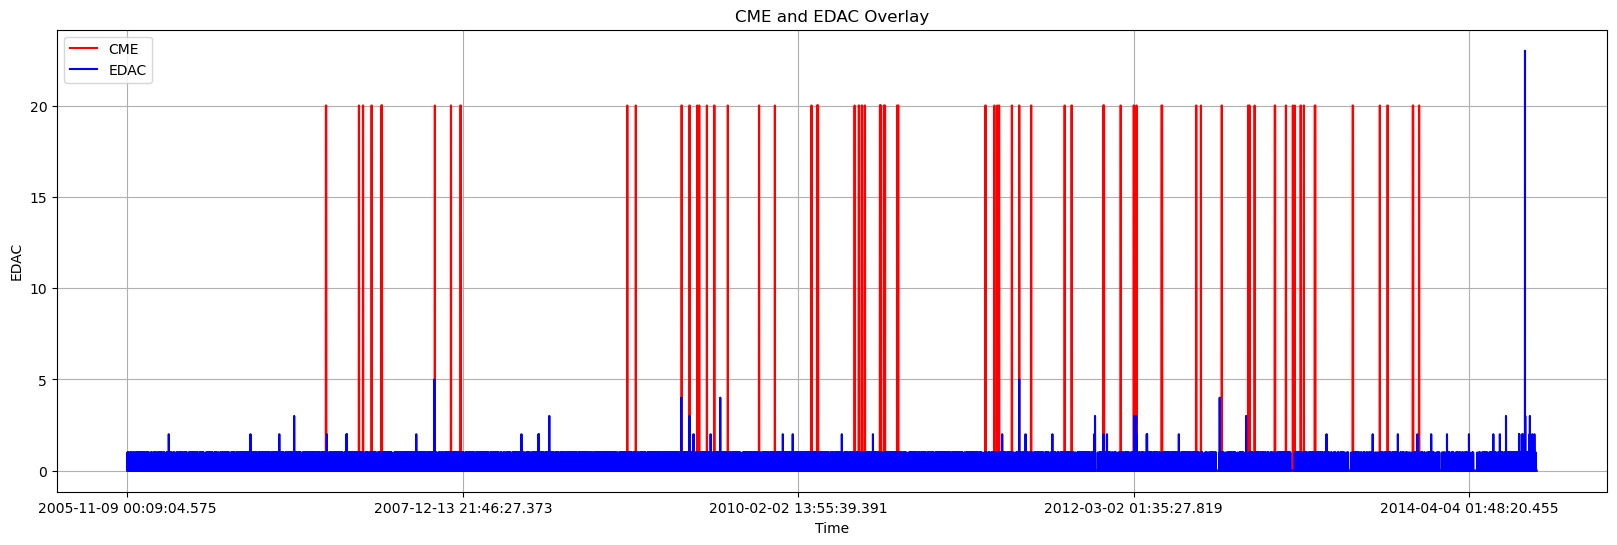

In [65]:
fig, ax = plt.subplots(figsize=(20, 6))

# Plot 'cme'
(vex_df['cme']*20).plot(kind='line', color='red', label='CME')

# Plot 'EDAC' on top of 'cme'
vex_df['EDAC'].plot(kind='line', color='blue', label='EDAC')

ax.set_xlabel('Time')
ax.set_ylabel('EDAC')

plt.title('CME and EDAC Overlay')
plt.grid()
plt.legend()
plt.show()

We can also look at the EDAC counter (sum) :

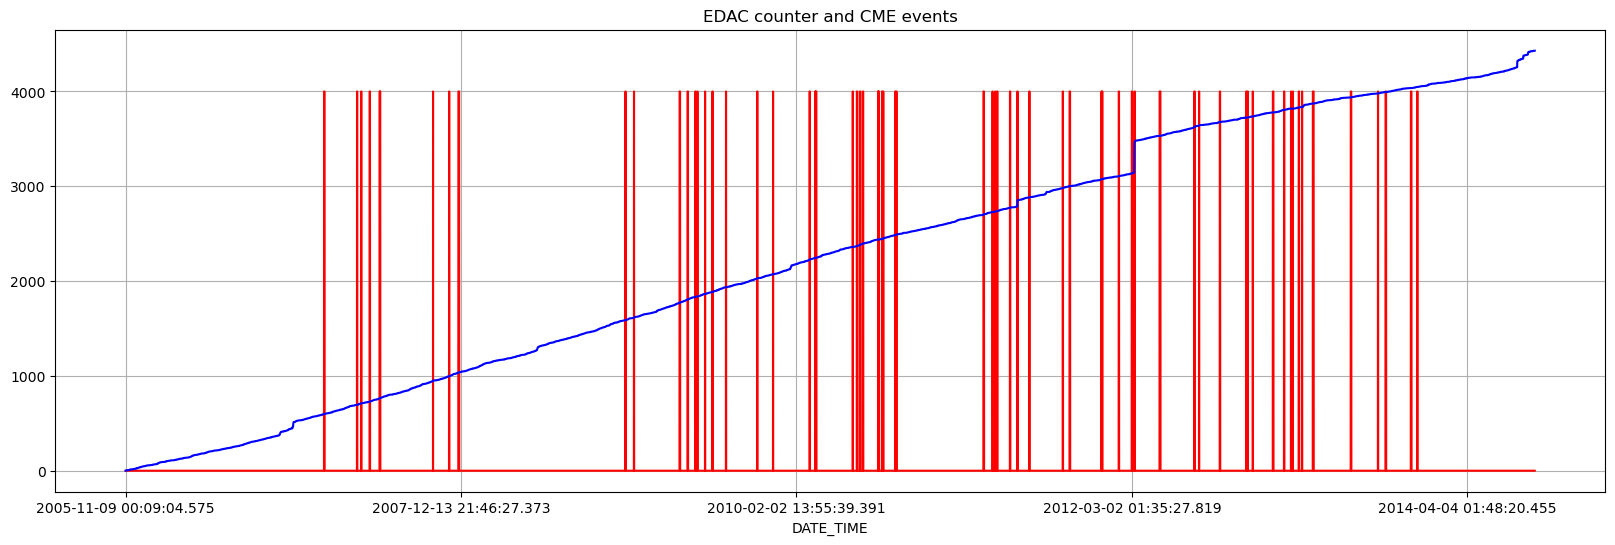

In [66]:
vex_df['EDAC_counter'] = vex_df['EDAC'].cumsum()

fig, ax = plt.subplots(figsize=(20, 6))
(vex_df['cme']*4000).plot(kind='line', color='red', label='CME')
vex_df['EDAC_counter'].plot(kind='line',color='blue', label='EDAC')

plt.title('EDAC counter and CME events')
plt.grid()
plt.show()

### Forbush decrease boundaries from Venus Express

In [67]:
# get the start and end date of a forbush event

# temporary fix of the bug until I find a prettier way:
vex_boundary_df['start'] = vex_boundary_df.apply(lambda t: 
                            pd.to_datetime(int(str(t.DiscontinuityDOY).split('.')[0]) * 24 * 60 * 60 
                                           + int(str(t.DiscontinuityDOY).split('.')[1])), axis=1)

# make a timestamp because the data is not in a known format to do smt pretty
vex_boundary_df['start'] = vex_boundary_df.apply(lambda t: 
                            pd.to_datetime(int(str(t.DiscontinuityDOY).split('.')[0]) * 24 * 60 * 60 
                                           + int(str(t.DiscontinuityDOY).split('.')[1]),
                                           origin=datetime.strptime(str(t.Year), '%Y'), unit='s'), axis=1)

vex_boundary_df['end'] = vex_boundary_df.apply(lambda t: 
                            pd.to_datetime(int(str(t.MCendDOY).split('.')[0]) * 24 * 60 * 60 
                                           + int(str(t.MCendDOY).split('.')[1]), 
                                           origin=datetime.strptime(str(t.Year), '%Y'), unit='s'), axis=1)

display(vex_boundary_df)

,Year,DiscontinuityDOY,MCstartDOY,MCendDOY,FRstartDOY,FRendDOY,rH,start,end
0,2007,44.200,44.6113,45.3981,44.6113,45.3981,0.725,2007-02-14 00:00:02,2007-02-15 01:06:21
1,2007,117.010,117.3700,117.6740,117.3700,117.6740,0.719,2007-04-28 00:00:01,2007-04-28 00:11:14
2,2007,126.030,126.3500,126.8700,126.3500,126.8700,0.719,2007-05-07 00:00:03,2007-05-07 00:01:27
3,2007,144.800,145.1500,145.8330,145.1500,145.8330,0.721,2007-05-25 00:00:08,2007-05-26 00:13:53
4,2007,167.094,167.0940,167.7200,167.0940,167.7200,0.724,2007-06-17 00:01:34,2007-06-17 00:01:12
...,...,...,...,...,...,...,...,...,...
62,2013,201.421,201.8820,202.7410,201.8820,202.7410,0.721,2013-07-21 00:07:01,2013-07-22 00:12:21
63,2013,261.487,261.4870,261.9390,261.4870,261.9390,0.728,2013-09-19 00:08:07,2013-09-19 00:15:39
64,2013,278.179,278.5230,279.6240,278.5230,279.6240,0.728,2013-10-06 00:02:59,2013-10-07 00:10:24
65,2013,334.188,334.5830,335.6670,334.5830,335.6670,0.723,2013-12-01 00:03:08,2013-12-02 00:11:07
